### Apakah Halaman Website yang Baru Akan Meningkatkan Tingkat Konversi?

In [2]:
import pandas as pd 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

In [8]:
# import dataset
data = pd.read_csv('abtest_website.csv')
data

,user_id,timestamp,group,landing_page,converted
0,688937,42:41.4,treatment,new_page,0
1,884319,43:36.9,treatment,new_page,0
2,692455,47:12.6,control,old_page,0
3,801251,47:27.9,control,old_page,1
4,637815,21:48.9,control,old_page,0
...,...,...,...,...,...
3565,894307,36:31.3,control,old_page,1
3566,753391,12:05.2,treatment,new_page,0
3567,807276,15:12.3,treatment,new_page,0
3568,836731,16:09.9,treatment,new_page,0


In [4]:
# ringkasan dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3570 entries, 0 to 3569
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       3570 non-null   int64 
 1   timestamp     3570 non-null   object
 2   group         3570 non-null   object
 3   landing_page  3570 non-null   object
 4   converted     3570 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 139.6+ KB


In [5]:
# jumlah missing values
data.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [6]:
# jumlah baris duplikat
data['user_id'].duplicated().sum()

0

#### Data Validation

Sanity Check

In [13]:
data.loc[(data['group'] == 'treatment') & (data['landing_page'] == 'old_page')].head()

,user_id,timestamp,group,landing_page,converted
42,869707,36:28.2,treatment,old_page,0
248,820951,42:54.8,treatment,old_page,0
643,839954,58:22.3,treatment,old_page,0
814,880442,42:39.0,treatment,old_page,0
1104,686623,26:40.7,treatment,old_page,0


In [14]:
data.loc[(data['group'] == 'control') & (data['landing_page'] == 'new_page')].head()

,user_id,timestamp,group,landing_page,converted
412,872666,44:32.1,control,new_page,0
547,858458,51:33.2,control,new_page,1
628,646342,39:23.5,control,new_page,0
666,639817,39:11.8,control,new_page,0
685,717682,05:39.9,control,new_page,0


Terdapat anomali data: 
- Kelompok `control` seharusnya hanya diberikan halaman web yang lama (old_page)
- Kelompok `treatment` seharusnya hanya diberikan halaman web yang baru (new_page)

In [16]:
# filtering data
data_control = data.loc[(data['group'] == 'control') & (data['landing_page'] == 'old_page')]
data_treatment =  data.loc[(data['group'] == 'treatment') & (data['landing_page'] == 'new_page')]

Kelompok eksperimen sudah valid :
- `control` -> `old_page`
- `treatment` -> `new_page`


##### Jumlah user, jumlah convert dan conversion rate

In [23]:
# jumlah user masing-masing kelompok
n_control = data_control.shape[0]
n_treatment = data_treatment.shape[0]

# jumlah user yang convert di masing-masing kelompok
data_control_convert = data_control[data_control['converted'] == 1]
data_treatment_convert = data_treatment[data_treatment['converted'] == 1]

n_control_convert = data_control_convert.shape[0]
n_treatment_convert = data_treatment_convert.shape[0]

# conversion rate masing-masing group
cr_control = round(n_control_convert / n_control, 3)
cr_treatment = round(n_treatment_convert / n_treatment, 3)

print(f"jumlah user yang convert di group control : {n_control_convert}")
print(f"jumlah user di group control : {n_control}")
print(f"conversion rate control : {cr_control}")
print(f"jumlah user yang convert di group treatment : {n_treatment_convert}")
print(f"jumlah user di group treatment : {n_treatment}")
print(f"conversion rate treatment : {cr_treatment}")

jumlah user yang convert di group control : 236
jumlah user di group control : 1768
conversion rate control : 0.133
jumlah user yang convert di group treatment : 234
jumlah user di group treatment : 1767
conversion rate treatment : 0.132


|Group|Jumlah User|Jumlah Convert|Conversion Rate|
|-----|-----|-----|-----|
|Control|1768|236|0.133|
|Treatment|1767|234|0.132|

C:\Users\ASUS\AppData\Local\Temp\ipykernel_25936\3368696790.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels=["control", "treatment"], fontsize=16)


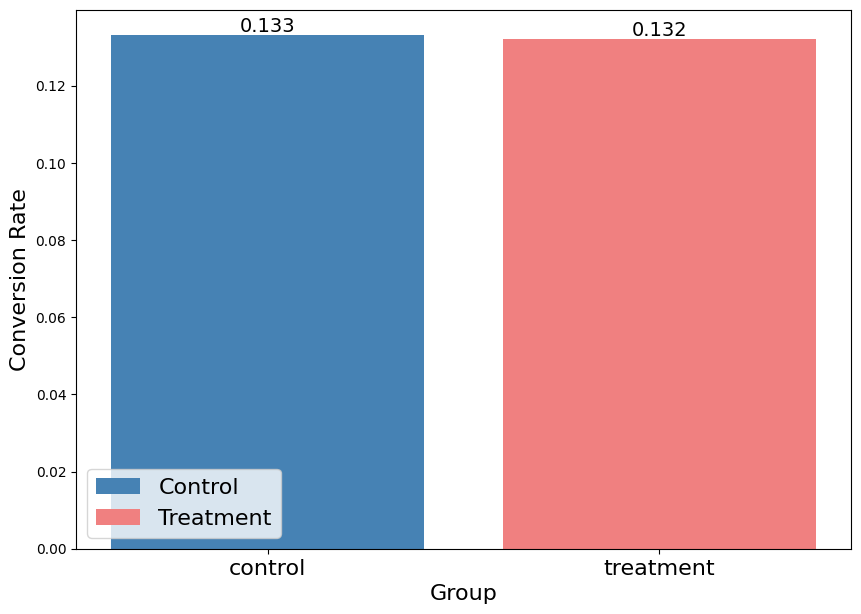

In [38]:
# Buat plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))

bars = ax.bar(["control", "treatment"], [cr_control, cr_treatment],
              color=["steelblue", "lightcoral"], label=["Control", "Treatment"])

# Styling plot
ax.set_ylabel("Conversion Rate", fontsize=16)
ax.set_xlabel("Group", fontsize=16)
ax.set_xticklabels(labels=["control", "treatment"], fontsize=16)
ax.legend(fontsize=16)

# Tambahkan label di atas bar
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2,   # posisi X di tengah bar
            height,                            # posisi Y di atas bar
            f"{height:.3f}",                   # teks label (format 2 desimal)
            ha='center', va='bottom', fontsize=14)

#### Uji Hipotesis

- **Apa yang ingin dibuktikan**: Rasio konversi atau proporsi konversi dari pengguna yang mendarat di **halaman baru** lebih besar daripada halaman **lama**.

- Misalkan $p_1$ adalah proporsi konversi dari pengguna yang mendarat di **halaman baru**, dan $p_2$ adalah proporsi konversi dari pengguna yang mendarat di **halaman lama**.

  - $H_0$: Probabilitas semua pengguna yang melakukan konversi dari halaman baru **kurang dari atau sama dengan** probabilitas konversi dari halaman lama.
    $$H_0: P_1 \leq P_2$$

- **Hipotesis alternatif ($H_1$)** adalah klaim yang berlawanan dengan hipotesis nol:
  - $H_1$: Probabilitas semua pengguna yang melakukan konversi dari halaman baru **lebih besar** daripada probabilitas konversi dari halaman lama.
    $$H_1: P_1 > P_2$$

- **Tingkat signifikansi (alpha)**:
  - Tingkat signifikansi = 0.05

In [36]:
# uji statistik
from statsmodels.stats.proportion import proportions_ztest

z_stat, p_value = proportions_ztest(count = [n_treatment_convert,n_control_convert],
                                       nobs = [n_treatment, n_control],
                                       alternative='larger')
print('Z-stat = ', np.round(test_stat, 4))
print('P_value = ', np.round(p_value, 4))

Z-stat =  -0.0925
P_value =  0.5368


In [33]:
# Keputusan berdasarkan p-value
alpha = 0.05

if p_value<alpha:
    print('Reject H0')
else:
    print('Fail to reject H0')

Fail to reject H0


In [34]:
# Keputusan berdasarkan critical value

import scipy.stats as stats
z_crit = stats.norm.ppf(1-alpha)
print('Critical value = ', np.round(z_crit, 4))

if test_stat > z_crit:
    print('Reject H0')
else:
    print('Fail to reject H0')

Critical value =  1.6449
Fail to reject H0


In [35]:
# confidence interval
from statsmodels.stats.proportion import confint_proportions_2indep

confidence_interval = confint_proportions_2indep(count1 = n_control_convert, nobs1 = n_control,
                                                 count2 = n_treatment_convert, nobs2 = n_treatment, 
                                                 compare='diff', alpha=0.05)
print(np.round(confidence_interval,4))

[-0.0214  0.0235]


|Z-stat|P-Value|$\alpha$|Confidence Interval|
|-----|-----|-----|-----|
|-0.0925|0.5368|0.05|[-0.0214     0.0235]|

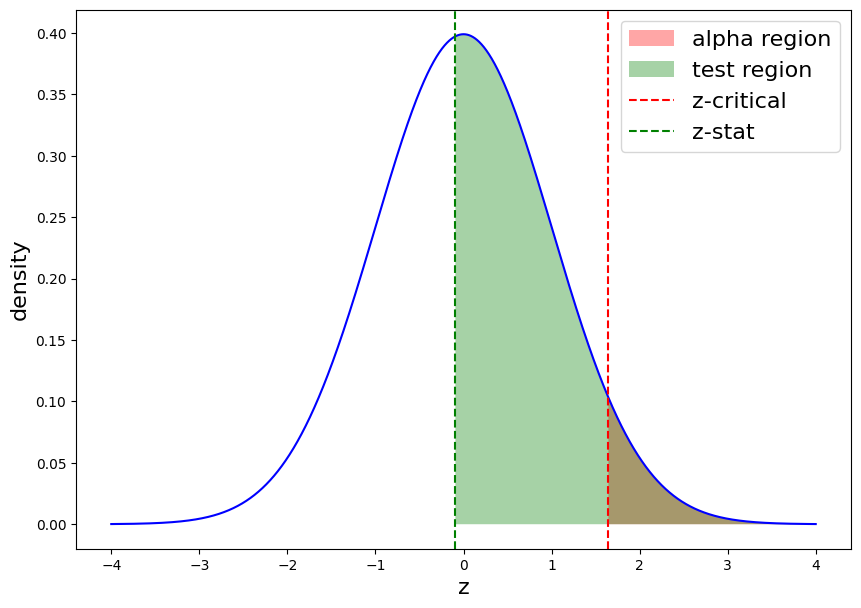

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))

# Plot distribusi sample
x_sample = np.arange(-4., 4., 0.001)
y_sample = stats.norm.pdf(x_sample, 0, 1)
ax.plot(x_sample, y_sample,
        color = "blue")

# Plot region dari alpha (region tempat menolak H-0)
# Region ini berwarna merah
x_alpha = np.arange(z_crit, 4., 0.001)
y_alpha = stats.norm.pdf(x_alpha)
ax.fill_between(x = x_alpha,
                y1 = y_alpha,
                facecolor = "red", 
                alpha = .35,
                label = "alpha region")


# Plot region dari sampel yang kita temukan
# Region ini berwarna hijau
x_test = np.arange(z_stat, 4., 0.001)
y_test = stats.norm.pdf(x_test)
ax.fill_between(x = x_test,
                y1 = y_test,
                facecolor = "green", 
                alpha = .35,
                label = "test region")


# Plot vertical line alpha
ax.axvline(z_crit, 
           color = "red",
           linestyle = "--",
           label = "z-critical")

# Plot vertical line test
ax.axvline(z_stat, 
           color = "green",
           linestyle = "--",
           label = "z-stat")


# Styling plot
ax.set_xlabel("z", fontsize=16)
ax.set_ylabel("density", fontsize=16)

plt.legend(fontsize=16)
plt.show()

**Kesimpulan**
- P_value lebih besar dari alpha (0,05), maka gagal menolak hipotesis nol.
- Oleh karena itu, berdasarkan data, kita tidak dapat menolak bahwa probabilitas semua pengguna yang melakukan konversi dari halaman baru kurang dari atau sama dengan probabilitas konversi dari halaman lama.
- Confidence Interval berada di antara `−0,0214 hingga 0,0235`, artinya kita yakin 95% bahwa halaman baru akan menarik pengguna untuk membeli produk perusahaan antara −0,02% hingga 0,02% dibandingkan halaman lama.

**Rekomendasi untuk bisnis**

Perusahaan sebaiknya tidak menggunakan halaman baru.